# Belgnaoui Mohammed Taha



Soit $(S_t)_{t \in [0,T]}$ un processus de Black-Scholes (Brownien géométrique) de paramètre $r$, $\sigma$ et de valeur initiale fixée $x_0 > 0$, c'est à dire $S_t = x_0 e^{(r-\frac{\sigma^2}{2}) t + \sigma W_t}$ où $(W_t)_{t \in [0,T]}$ est un mouvement Brownien standard.

On considère des dates discrètes fixées $t_n = n \frac{T}{N}$ pour $n = 0, \dots, N$. La valeur de l'actif aux instants $t_n$ forme une chaine de Markov que l'on note $(X_n)_{n = 0,\dots,N}$ c'est à dire 
$$
    \forall n=0, \dots, N, \quad X_n = S_{t_n}
$$
Le put Bermudéen est une option que l'on peut exercer à toute date $t_n$.  Si on exerce en $t_n$ le gain associé (le payoff) est 
$$
    Z_n = \varphi(n, X_n) = e^{-r n \frac{T}{N}} (K - X_n)_+.
$$

On s'intéresse donc au problème d'arrêt optimal à temps discret 
$$
    V_0(x_0) = \sup_{\tau \in \mathcal{T}_0} \mathbf{E}\big[ Z_\tau \big]
    = \sup_{\tau \in \mathcal{T}_0} \mathbf{E}\big[ \varphi(\tau, X_\tau) \big],,
$$
où $\mathcal{T}_0$ est l'ensemble des temps d'arrêts à valeur dans $\{0,\dots,N\}$.

L'objectif de ce TP est d'implémenter l'algorithme de Longstaff-Schwartz et de comparer une version basée sur une régression linéaire avec une version utilisant un réseau de neurones (régression non linéaire) pour estimer la fonction de continuation.

Au cours de ce TP, j'ai utilisé la bibliothèque Keras afin d'implémenter le réseau de neurones.

Plusieurs configurations de réseaux (nombre de couches et de neurones par couche) ont été testées afin de déterminer les plus performantes, bien que les détails précis de ces configurations ne soient pas explicités dans ce notebook.

Dans un premier temps, les résultats obtenus par régression polynomiale sont rappelés. Ensuite, l'algorithme de Longstaff-Schwartz est implémenté sans normalisation des données, puis avec normalisation. Par la suite, j'ai étudié l'influence du nombre d'époch et du learning rate sur les résultats obtenus.





In [ ]:
import numpy as np
from scipy import stats
from numpy.random import default_rng
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import seaborn as sns
rng = default_rng()


In [ ]:
#paramétres
r=0.1
sigma=0.25
x_0=100
K=110
N=10   
T=1
npaths=int(1e5)
ts = np.linspace(0, T, N+1)

In [28]:
# Simulation Monte-Carlo du processus Black-Scholes

def blackscholes_mc(S, vol, r, ts, npaths):

    nsteps = len(ts) - 1
    ts = np.asarray(ts)[:, np.newaxis]
    W = np.cumsum(np.vstack((np.zeros((1, npaths)),
                             np.random.randn(nsteps, npaths) * np.sqrt(np.diff(ts, axis=0)))),
                  axis=0)
    paths = np.exp(-0.5*vol**2*ts + vol*W)*S*np.exp((r)*ts)
    return paths


paths=blackscholes_mc(x_0, sigma, r, ts, npaths)



# Régression polynomiale

In [114]:
def monte_carlo(sample, proba = 0.95):
    mean = np.mean(sample)
    var = np.var(sample, ddof=1)
    alpha = 1 - proba 
    quantile = stats.norm.ppf(1 - alpha/2)  # fonction quantile 
    ci_size = quantile * np.sqrt(var / sample.size)
    result = { 'mean': mean, 'var': var, 
               'lower': mean - ci_size, 
               'upper': mean + ci_size }
    return result

In [ ]:
payoff = np.maximum(K - paths[-1], 0).copy()

# Matrice pour stocker les coefficients du polynôme
poly_coeffs = np.zeros((len(ts) - 1, 4))  


for i in range(len(ts) - 2, 0, -1):
    discount = np.exp(-r * (ts[i + 1] - ts[i]))
    payoff *= discount
    
    # Régression polynomiale
    p = np.polyfit(paths[i], payoff, deg=3)
    poly_coeffs[i] = p  
    contval = np.polyval(p, paths[i])  # Valeur de continuation
    exerval = np.maximum(K - paths[i], 0)  # Valeur d'exercice
    
    # Identifier les chemins où il faut exercer
    ind = exerval > contval
    payoff[ind] = exerval[ind]


print("Valeur de l'option:",(np.mean(payoff*np.exp(-r*(ts[1]-ts[0])))))

print(monte_carlo(payoff*np.exp(-r*(ts[1]-ts[0])), proba = 0.95))

Valeur de l'option: 11.907265245381332
{'mean': np.float64(11.907265245381332), 'var': np.float64(85.4463824255725), 'lower': np.float64(11.889147884661153), 'upper': np.float64(11.925382606101511)}


# Régression (réseau de neuronnes)

In [30]:

def create_model(layers_shapes, learning_rate):
    model = Sequential()
    # Ajout de la première couche cachée avec la dimension d'entrée
    model.add(Dense(layers_shapes[1], activation='relu', input_shape=(layers_shapes[0],)))
    # Ajout des autres couches cachées s'il y en a
    for units in layers_shapes[2:-1]:
        model.add(Dense(units, activation='relu'))
    # Couche de sortie (activation linéaire par défaut)
    model.add(Dense(layers_shapes[-1]))
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mse')
    return model




In [113]:
# Fonction d'entraînement du réseau de neurones
def neural_network(x, y, layers_shapes, batch_size, epochs, learning_rate=0.001):
    # Mise en forme des données d'entrée et de sortie



    x = np.array(x).reshape(-1, layers_shapes[0])
    y = np.array(y).reshape(-1, layers_shapes[-1])


    #x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=test_size, random_state=42)
    
    

    # Création et compilation du modèle
    model = create_model(layers_shapes, learning_rate)
    early_stopping = EarlyStopping(monitor='loss', patience=3, restore_best_weights=True)
    # Entraînement du modèle
    model.fit(x, y, batch_size=batch_size, callbacks=[early_stopping], epochs=epochs, verbose=0) 
    #print(f'Epoch {epochs}/{epochs}, Loss: {history.history["loss"][-1]}')
    
    # Retourner le modèle entraîné pour pouvoir l'utiliser en prédiction
    return model

In [ ]:
layers_shapes=[1,120,60,30,1]
learning_rate=1e-3
epochs=5
batch_size=150

In [95]:

payoff = np.maximum(K - paths[-1], 0).copy()

# Initialiser la liste pour stocker les paramètres du réseau à chaque pas de temps
nn_parametres = [None] * len(ts)

# Boucle de régression en remontant dans le temps
for i in range(len(ts) - 2, 0, -1):
    print(i)
    discount = np.exp(-r * (ts[i + 1] - ts[i]))
    payoff *= discount
    
    # Entraînement du modèle pour approximer la valeur de continuation à l'instant i
    #model= neural_network(paths[i], payoff, layers_shapes, batch_size, epochs, learning_rate)

    
    #m,e = np.mean(paths[i]),np.std(paths[i])
    # Entraînement du modèle pour approximer la valeur de continuation à l'instant i
    model= neural_network(np.array(paths[i]), payoff, layers_shapes, batch_size, epochs, learning_rate)
    


    # Stockage des poids du modèle dans la liste
    nn_parametres[i] = model.get_weights()
    
    # Calcul de la valeur de continuation via la prédiction du modèle
    
    contval = model.predict(np.array(paths[i]).reshape(-1, layers_shapes[0]))
    
    # Calcul de la valeur d'exercice immédiat
    exerval = np.maximum(K - np.array(paths[i]), 0)
    
    # Pour comparer, on aplatit contval au besoin (il s'agit d'un tableau 2D)
    ind = exerval > contval.flatten()
    payoff[ind] = exerval[ind]




9
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step
8
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step
7
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step
6
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step
5
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step
4
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step
3
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step
2
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step
1
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step


c:\elkaroui\projet lemaire\venv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step


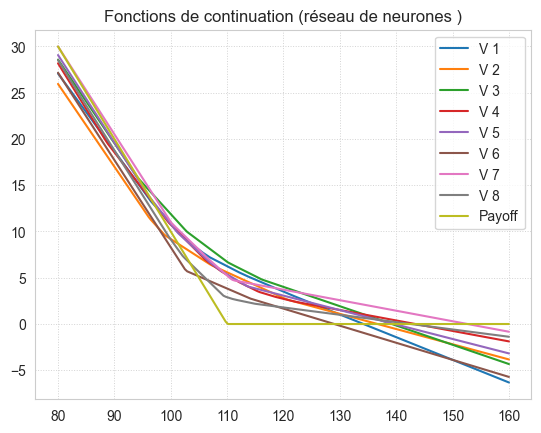

In [104]:

# Style et paramètres d'affichage
sns.set_style("whitegrid")
plt.rcParams['figure.dpi'] = 100
params_grid = {"color": 'lightgrey', "linestyle": 'dotted', "linewidth": 0.7}

X = np.linspace(80, 160, 200)  # 110 + 50 = 160
exer = np.maximum(0, K - X)

# Ajoute la grille personnalisée
plt.grid(**params_grid)

for i, weights in enumerate(nn_parametres):

    model_temp = create_model(layers_shapes, learning_rate)
    model_temp.set_weights(weights)
    y_plot = model_temp.predict(X)
    plt.plot(X, y_plot.flatten(), label=f"V {i+1}")
    #plt.plot(X, np.maximum(y_plot.flatten(), exer), label=f"V {i+1}")

plt.plot(X, exer, label="Payoff")

plt.title("Fonctions de continuation (réseau de neurones )")
plt.legend()
plt.show()


In [106]:
print("Valeur de l'option:",(np.mean(payoff*np.exp(-r*(ts[1]-ts[0])))))

print(monte_carlo(payoff*np.exp(-r*(ts[1]-ts[0])), proba = 0.95))

Valeur de l'option: 11.748404166445324
{'mean': np.float64(11.748404166445324), 'var': np.float64(70.92370167200741), 'lower': np.float64(11.69620737733103), 'upper': np.float64(11.800600955559618)}


# Normalisation

In [ ]:
layers_shapes=[1,120,60,30,1]
learning_rate=1e-3
epochs=5
batch_size=150

In [ ]:

normal_coef=[]
payoff = np.maximum(K - paths[-1], 0).copy()

# Initialiser la liste pour stocker les paramètres du réseau à chaque pas de temps
nn_parametres = [None] * len(ts)

# Boucle de régression en remontant dans le temps
for i in range(len(ts) - 2, 0, -1):
    print(i)
    discount = np.exp(-r * (ts[i + 1] - ts[i]))
    payoff *= discount
    
   

    
    m,e = np.mean(paths[i]),np.std(paths[i])
  
    model= neural_network((np.array(paths[i])-m)/e, payoff, layers_shapes, batch_size, epochs, learning_rate)
    normal_coef.append([m,e])


    nn_parametres[i] = model.get_weights()
    
   
    
    contval = model.predict(((np.array(paths[i])-m)/e).reshape(-1, layers_shapes[0]))
    
    
    exerval = np.maximum(K - np.array(paths[i]), 0)
    
    
    ind = exerval > contval.flatten()
    payoff[ind] = exerval[ind]




In [ ]:
nn_parametres.pop(0)
nn_parametres.pop(-1)
normal_coef.pop(0)
normal_coef.pop(-1)
X=np.linspace(110-50, 110+50, 200)
exer=np.maximum(0,K-X)
np.maximum(y_plot.flatten(),exer)

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


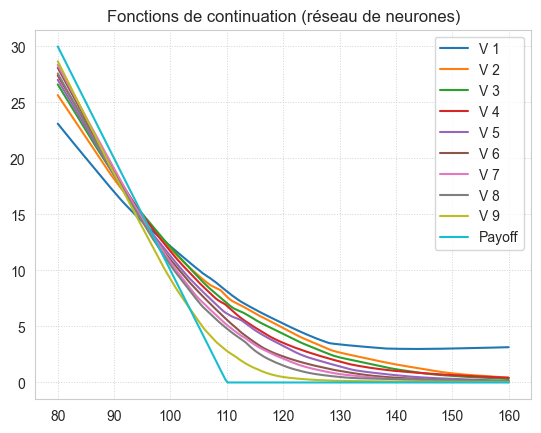

In [ ]:
sns.set_style("whitegrid")
plt.rcParams['figure.dpi'] = 100
params_grid = {"color": 'lightgrey', "linestyle": 'dotted', "linewidth": 0.7}

X = np.linspace(80, 160, 200)  
exer = np.maximum(0, K - X)


plt.grid(**params_grid)

for i, weights in enumerate(nn_parametres):
    m, e = normal_coef[-(i+1)]
    x_plot = ((X - m) / e).reshape(-1, layers_shapes[0])

    model_temp = create_model(layers_shapes, learning_rate)
    model_temp.set_weights(weights)
    y_plot = model_temp.predict(x_plot)
    plt.plot(X, y_plot.flatten(), label=f"V {i+1}")
   

plt.plot(X, exer, label="Payoff")

plt.title("Fonctions de continuation (réseau de neurones)")
plt.legend()
plt.show()


In [ ]:
print("Valeur de l'option:",max(np.mean(payoff*np.exp(-r*(ts[1]-ts[0]))),10)) # K-x_0=10
print(monte_carlo(payoff*np.exp(-r*(ts[1]-ts[0]))))

Valeur de l'option: 11.96081055960417
{'mean': np.float64(11.96081055960417), 'var': np.float64(83.33073137326507), 'lower': np.float64(11.904232156209524), 'upper': np.float64(12.017388962998815)}


### Les simulations effectuées montrent clairement que la normalisation améliore les résultats . Dans la suite, nous utiliserons systématiquement des données normalisées.

# Influence du nombre d'epochs

In [115]:
layers_shapes=[1,120,60,30,1]
learning_rate=1e-3
epochs=10
batch_size=150

In [ ]:

normal_coef=[]
payoff = np.maximum(K - paths[-1], 0).copy()


nn_parametres = [None] * len(ts)


for i in range(len(ts) - 2, 0, -1):
    print(i)
    discount = np.exp(-r * (ts[i + 1] - ts[i]))
    payoff *= discount
    
    

    
    m,e = np.mean(paths[i]),np.std(paths[i])
  
    model= neural_network((np.array(paths[i])-m)/e, payoff, layers_shapes, batch_size, epochs, learning_rate)
    normal_coef.append([m,e])


   
    nn_parametres[i] = model.get_weights()
    
    
    
    contval = model.predict(((np.array(paths[i])-m)/e).reshape(-1, layers_shapes[0]))
    
    
    exerval = np.maximum(K - np.array(paths[i]), 0)
    
    
    ind = exerval > contval.flatten()
    payoff[ind] = exerval[ind]




In [ ]:
nn_parametres.pop(0)
nn_parametres.pop(-1)
normal_coef.pop(-1)

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step


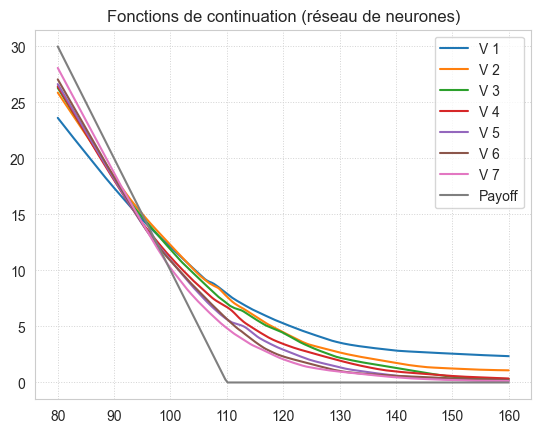

In [ ]:

X=np.linspace(110-50, 110+50, 200)
exer=np.maximum(0,K-X)
np.maximum(y_plot.flatten(),exer)


X = np.linspace(80, 160, 200)  
exer = np.maximum(0, K - X)


plt.grid(**params_grid)

for i, weights in enumerate(nn_parametres):
    if i<7:
        m, e = normal_coef[-(i+1)]
        x_plot = ((X - m) / e).reshape(-1, layers_shapes[0])

        model_temp = create_model(layers_shapes, learning_rate)
        model_temp.set_weights(weights)
        y_plot = model_temp.predict(x_plot)
        plt.plot(X, y_plot.flatten(), label=f"V {i+1}")
    

plt.plot(X, exer, label="Payoff")

plt.title("Fonctions de continuation (réseau de neurones)")
plt.legend()
plt.show()


In [128]:
print("Valeur de l'option:",(np.mean(payoff*np.exp(-r*(ts[1]-ts[0]))))) # K-x_0=10
print(monte_carlo(payoff*np.exp(-r*(ts[1]-ts[0]))))

Valeur de l'option: 11.942087430424165
{'mean': np.float64(11.942087430424165), 'var': np.float64(83.74885252827052), 'lower': np.float64(11.88536726044313), 'upper': np.float64(11.998807600405199)}


# Influence du learning rate 

In [131]:
layers_shapes=[1,120,60,30,1]
learning_rate=1e-4
epochs=10
batch_size=150

In [132]:

normal_coef=[]
payoff = np.maximum(K - paths[-1], 0).copy()

# Initialiser la liste pour stocker les paramètres du réseau à chaque pas de temps
nn_parametres = [None] * len(ts)

# Boucle de régression en remontant dans le temps
for i in range(len(ts) - 2, 0, -1):
    print(i)
    discount = np.exp(-r * (ts[i + 1] - ts[i]))
    payoff *= discount
  

    
    m,e = np.mean(paths[i]),np.std(paths[i])
    
    model= neural_network((np.array(paths[i])-m)/e, payoff, layers_shapes, batch_size, epochs, learning_rate)
    normal_coef.append([m,e])


    
    nn_parametres[i] = model.get_weights()
    
    
    
    contval = model.predict(((np.array(paths[i])-m)/e).reshape(-1, layers_shapes[0]))
    
   
    exerval = np.maximum(K - np.array(paths[i]), 0)
    
    
    ind = exerval > contval.flatten()
    payoff[ind] = exerval[ind]




9
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step
8
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step
7
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step
6
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step
5
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step
4
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step
3
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step
2
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step
1
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step


In [136]:
nn_parametres.pop(0)
nn_parametres.pop(-1)
normal_coef.pop(-1)

[np.float64(101.00884603863004), np.float64(8.009899425089518)]

c:\elkaroui\projet lemaire\venv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


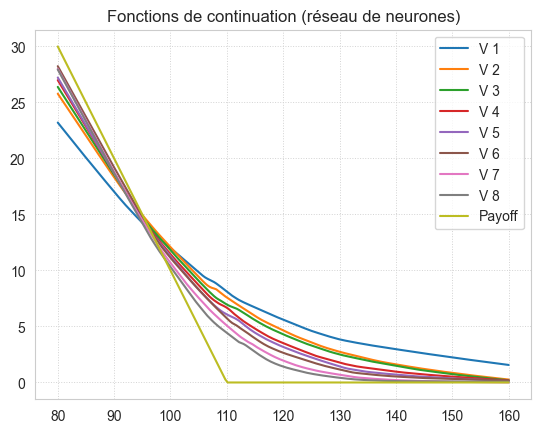

In [142]:

X=np.linspace(110-50, 110+50, 200)
exer=np.maximum(0,K-X)



X = np.linspace(80, 160, 200)  
exer = np.maximum(0, K - X)


plt.grid(**params_grid)

for i, weights in enumerate(nn_parametres):
    if i<8:
        m, e = normal_coef[-(i+1)]
        x_plot = ((X - m) / e).reshape(-1, layers_shapes[0])

        model_temp = create_model(layers_shapes, learning_rate)
        model_temp.set_weights(weights)
        y_plot = model_temp.predict(x_plot)
        plt.plot(X, y_plot.flatten(), label=f"V {i+1}")
    

plt.plot(X, exer, label="Payoff")

plt.title("Fonctions de continuation (réseau de neurones)")
plt.legend()
plt.show()


In [133]:
print("Valeur de l'option:",(np.mean(payoff*np.exp(-r*(ts[1]-ts[0]))))) # K-x_0=10
print(monte_carlo(payoff*np.exp(-r*(ts[1]-ts[0]))))

Valeur de l'option: 11.950005684661855
{'mean': np.float64(11.950005684661855), 'var': np.float64(81.21397668154937), 'lower': np.float64(11.894150501635838), 'upper': np.float64(12.005860867687872)}


# Conclusion

 Les simulations effectuées montrent clairement que la normalisation améliore significativement les résultats, le temps d'entraînement avec la méthode neuronale est considérablement plus long que celui de la régression polynomiale, mais il permet d'obtenir de bons résultats à condition d'effectuer un choix adéquat des paramètres. En effet, une grande partie du travail avec les réseaux de neurones consiste à rechercher les bons paramètres. Pour un pricing rapide ou des contrats simples, une régression polynomiale pourrait être suffisante, tandis que pour d'autres cas plus complexes, l'utilisation d'un réseau neuronal pourrait être avantageuse.

